this is the previous code, i've just kept it here for reference.
please scroll down for the relavent code

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving binary_classification.csv to binary_classification (1).csv


In [ ]:
# Combine utils, linear_regression, and perceptron into one cell
from typing import List, Tuple, Sequence, Dict, Any
import csv
import json
import time
import os
import math
import random
import argparse

# utils.py
def load_csv_xy(path: str, label_col: str = "label"):
    with open(path, newline="") as f:
        reader = csv.DictReader(f)
        if reader.fieldnames is None:
            raise ValueError(f"{path}: missing header row.")
        if label_col not in reader.fieldnames:
            raise ValueError(f"{path}: expected a '{label_col}' column. Found: {reader.fieldnames}")
        feats = [c for c in reader.fieldnames if c != label_col]
        if not feats:
            raise ValueError(f"{path}: no feature columns besides '{label_col}'.")
        X, y = [], []
        line = 1  # header=1
        for row in reader:
            line += 1
            try:
                X.append([float(row[c]) for c in feats])
            except (TypeError, ValueError):
                raise ValueError(f"{path}: non-numeric feature at line {line}.")
            try:
                y.append(int(row[label_col]))
            except (TypeError, ValueError):
                raise ValueError(f"{path}: non-integer label at line {line}.")
    return X, y, feats


def train_test_split(X: Sequence[Sequence[float]], y: Sequence[int], test_size: float = 0.2):
    """Deterministic split by index (no shuffle)."""
    n = len(X)
    n_test = int(n * test_size)
    n_train = n - n_test
    Xtr = [list(X[i]) for i in range(n_train)]
    ytr = [y[i] for i in range(n_train)]
    Xte = [list(X[i]) for i in range(n_train, n)]
    yte = [y[i] for i in range(n_train, n)]
    return Xtr, Xte, ytr, yte


def standardize_fit(X: Sequence[Sequence[float]]) -> Tuple[List[float], List[float]]:
    """Compute mean/std per feature (std≥1e-12)."""
    n = len(X)
    d = len(X[0]) if n else 0
    means = [0.0]*d
    for row in X:
        for j, v in enumerate(row):
            means[j] += v
    means = [m / n for m in means]
    var = [0.0]*d
    for row in X:
        for j, v in enumerate(row):
            dv = v - means[j]
            var[j] += dv*dv
    stds = [(v/max(n, 1))**0.5 for v in var]
    stds = [s if s > 1e-12 else 1.0 for s in stds]
    return means, stds


def standardize_apply(X: Sequence[Sequence[float]], means: Sequence[float], stds: Sequence[float]) -> List[List[float]]:
    """Apply z-score using provided mean/std."""
    Z = []
    for row in X:
        Z.append([(row[j]-means[j])/stds[j] for j in range(len(row))])
    return Z


def accuracy(y_true: Sequence[int], y_pred: Sequence[int]) -> float:
    """Simple accuracy."""
    n = len(y_true)
    return sum(1 for a, b in zip(y_true, y_pred) if a == b) / float(n or 1)


def now_iso() -> str:
    return time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())


def time_block() -> float:
    """Return perf_counter() — call twice to diff."""
    return time.perf_counter()


def avg_predict_time_us(predict_fn, X: Sequence[Sequence[float]], loops: int = 100) -> float:
    """Average microseconds per sample over multiple loops."""
    # warmup
    _ = predict_fn(X)
    start = time.perf_counter()
    for _ in range(loops):
        _ = predict_fn(X)
    end = time.perf_counter()
    total_preds = loops * len(X)
    return ((end - start) / float(total_preds or 1)) * 1e6


def save_json(obj: Dict[str, Any], path: str) -> None:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)


def save_csv(rows: List[List[Any]], header: List[str], path: str) -> None:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(header)
        w.writerows(rows)

# linear_regression.py
def _dot(a: Sequence[float], b: Sequence[float]) -> float:
    s = 0.0
    for x, y in zip(a, b):
        s += x*y
    return s


def _add_bias(X: Sequence[Sequence[float]]) -> List[List[float]]:
    return [list(row) + [1.0] for row in X]


class LinearRegressionGD:
    def __init__(self, lr: float = 0.1, max_iters: int = 2000, tol: float = 1e-6):
        self.lr = lr
        self.max_iters = max_iters
        self.tol = tol
        self.w: List[float] = []
        self.n_iters_ = 0
        self.converged_ = False
        self.train_time_sec_ = 0.0
        self.final_loss_ = None

    def fit(self, X: Sequence[Sequence[float]], y: Sequence[int]) -> "LinearRegressionGD":
        Xb = _add_bias(X)
        n, d = len(Xb), len(Xb[0])
        self.w = [0.0]*d
        prev = float("inf")
        t0 = time.perf_counter()
        for it in range(1, self.max_iters+1):
            # preds and loss
            preds = [_dot(self.w, xi) for xi in Xb]
            loss = 0.0
            for pi, yi in zip(preds, y):
                e = pi - yi
                loss += e*e
            loss /= (n or 1)
            # grad = (2/n) * Xb^T (pred - y)
            grad = [0.0]*d
            for xi, pi, yi in zip(Xb, preds, y):
                e = (pi - yi) * (2.0 / (n or 1))
                for j in range(d):
                    grad[j] += e * xi[j]
            # update
            for j in range(d):
                self.w[j] -= self.lr * grad[j]
            self.n_iters_ = it
            self.final_loss_ = loss
            # stop on small relative improvement
            if prev != float("inf"):
                denom = abs(prev) if abs(prev) > 1e-12 else 1.0
                rel = abs(prev - loss)/denom
                if rel < self.tol:
                    self.converged_ = True
                    break
            prev = loss
        self.train_time_sec_ = time.perf_counter() - t0
        return self

    def predict_scores(self, X: Sequence[Sequence[float]]) -> List[float]:
        Xb = _add_bias(X)
        return [_dot(self.w, xi) for xi in Xb]

    def predict(self, X: Sequence[Sequence[float]]) -> List[int]:
        # 0/1 via 0.5 threshold
        scores = self.predict_scores(X)
        return [1 if s >= 0.5 else 0 for s in scores]

# perceptron.py
def _dot(a, b):
    s = 0.0
    for x, y in zip(a, b):
        s += x*y
    return s


def _add_bias(X: Sequence[Sequence[float]]) -> List[List[float]]:
    return [list(row) + [1.0] for row in X]


class Perceptron:
    def __init__(self, max_iters: int = 2000, shuffle: bool = True, seed: int = 0):
        self.max_iters = max_iters
        self.shuffle = shuffle
        self.seed = seed
        self.w: List[float] = []
        self.n_iters_ = 0
        self.converged_ = False
        self.train_time_sec_ = 0.0
        self.mistakes_last_epoch_ = None

    def fit(self, X: Sequence[Sequence[float]], y: Sequence[int]) -> "Perceptron":
        Xb = _add_bias(X)
        n, d = len(Xb), len(Xb[0])
        self.w = [0.0]*d
        ybin = [1 if yi == 1 else -1 for yi in y]
        idx = list(range(n))
        rng = random.Random(self.seed)
        t0 = time.perf_counter()
        for it in range(1, self.max_iters+1):
            if self.shuffle:
                rng.shuffle(idx)
            mistakes = 0
            for i in idx:
                xi = Xb[i]
                yi = ybin[i]
                pred = 1 if _dot(self.w, xi) >= 0 else -1
                if pred != yi:
                    # w <- w + yi*xi
                    for j in range(d):
                        self.w[j] += yi * xi[j]
                    mistakes += 1
            self.n_iters_ = it
            self.mistakes_last_epoch_ = mistakes
            if mistakes == 0:
                self.converged_ = True
                break
        self.train_time_sec_ = time.perf_counter() - t0
        return self

    def predict_scores(self, X: Sequence[Sequence[float]]) -> List[float]:
        Xb = _add_bias(X)
        return [_dot(self.w, xi) for xi in Xb]

    def predict(self, X: Sequence[Sequence[float]]) -> List[int]:
        return [1 if s >= 0.0 else 0 for s in self.predict_scores(X)]

# analysis.py functions (excluding main and imports)
def run_one(dataset_name: str, path: str, standardize: bool) -> List[Dict[str, Any]]:
    X, y, _ = load_csv_xy(path)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2)

    if standardize:
        mu, sd = standardize_fit(Xtr)
        Xtr = standardize_apply(Xtr, mu, sd)
        Xte = standardize_apply(Xte, mu, sd)

    out: List[Dict[str, Any]] = []

    # Linear Regression
    lr = LinearRegressionGD(lr=0.1, max_iters=2000, tol=1e-6)
    lr.fit(Xtr, ytr)
    yp = lr.predict(Xte)
    acc = accuracy(yte, yp)
    tpp = avg_predict_time_us(lr.predict, Xte, loops=100)
    out.append({
        "timestamp": now_iso(),
        "dataset": dataset_name,
        "model": "linear_regression",
        "accuracy": acc,
        "time_to_convergence_sec": lr.train_time_sec_,
        "time_per_prediction_us": tpp,
        "n_iters": lr.n_iters_,
        "converged": lr.converged_,
        "final_loss": lr.final_loss_,
    })

    # Perceptron
    p = Perceptron(max_iters=2000, shuffle=True, seed=0)
    p.fit(Xtr, ytr)
    yp = p.predict(Xte)
    acc = accuracy(yte, yp)
    tpp = avg_predict_time_us(p.predict, Xte, loops=100)
    out.append({
        "timestamp": now_iso(),
        "dataset": dataset_name,
        "model": "perceptron",
        "accuracy": acc,
        "time_to_convergence_sec": p.train_time_sec_,
        "time_per_prediction_us": tpp,
        "n_iters": p.n_iters_,
        "converged": p.converged_,
        "mistakes_last_epoch": p.mistakes_last_epoch_,
    })

    return out

In [ ]:
# ===== analysis.py (single dataset) =====
import argparse
import os
from typing import List, Dict, Any

ap = argparse.ArgumentParser()
ap.add_argument("--data-a", required=False,
                default="/content/binary_classification.csv",
                help="Path to the single CSV with a 'label' column")
ap.add_argument("--standardize", default="true",  # "true"/"false"
                help="Whether to z-score features using training stats")
ap.add_argument("--outdir", default=".",
                help="Directory to write metrics.json and metrics.csv")
# In Colab, pass empty argv so argparse doesn't read notebook args
args = ap.parse_args(args=[])

std = str(args.standardize).lower() in ("1", "true", "yes", "y", "t")

# Run one dataset
rows: List[Dict[str, Any]] = []
rows += run_one("binary_classification", args.data_a, std)

# Save metrics (JSON)
os.makedirs(args.outdir, exist_ok=True)
json_obj = {"runs": rows}
json_path = os.path.join(args.outdir, "metrics.json")
save_json(json_obj, json_path)

# Save metrics (CSV)
header = [
    "timestamp", "dataset", "model", "accuracy",
    "time_to_convergence_sec", "time_per_prediction_us",
    "n_iters", "converged", "final_loss", "mistakes_last_epoch"
]
csv_rows = []
for r in rows:
    csv_rows.append([
        r.get("timestamp"),
        r.get("dataset"),
        r.get("model"),
        r.get("accuracy"),
        r.get("time_to_convergence_sec"),
        r.get("time_per_prediction_us"),
        r.get("n_iters"),
        r.get("converged"),
        r.get("final_loss"),
        r.get("mistakes_last_epoch"),
    ])
csv_path = os.path.join(args.outdir, "metrics.csv")
save_csv(csv_rows, header, csv_path)

# Console summary
print("\n=== Results ===")
for r in rows:
    print(f"{r['dataset']:>30} | {r['model']:>18} | acc={r['accuracy']:.3f} | "
          f"train={r['time_to_convergence_sec']:.4f}s | pred={r['time_per_prediction_us']:.2f}us "
          f"| iters={r['n_iters']} | conv={r['converged']}")

print(f"\nSaved: {json_path}\nSaved: {csv_path}")



=== Results ===
         binary_classification |  linear_regression | acc=0.990 | train=0.0221s | pred=0.46us | iters=39 | conv=True
         binary_classification |         perceptron | acc=0.990 | train=0.9772s | pred=0.45us | iters=2000 | conv=False

Saved: ./metrics.json
Saved: ./metrics.csv


<Figure size 640x480 with 0 Axes>

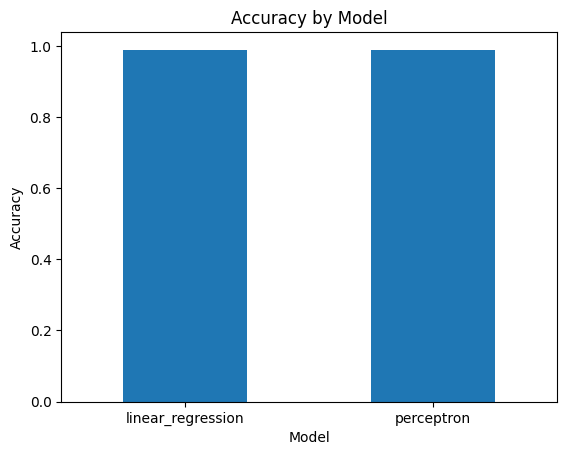

<Figure size 640x480 with 0 Axes>

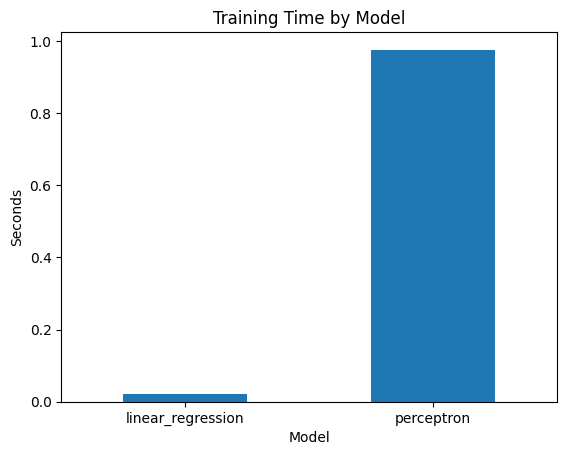

<Figure size 640x480 with 0 Axes>

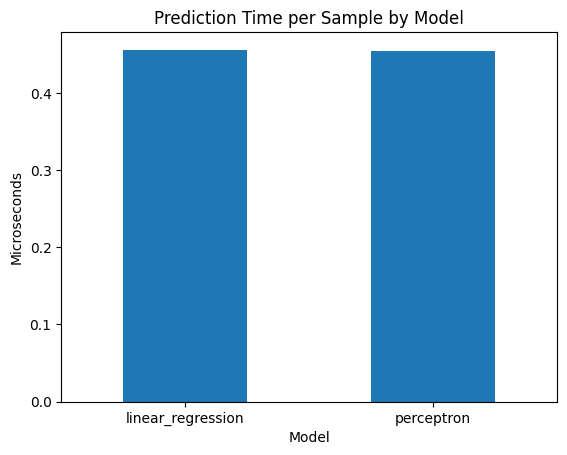

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("metrics.csv")

# Accuracy
plt.figure()
df.plot(kind="bar", x="model", y="accuracy", legend=False)
plt.title("Accuracy by Model")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.show()

# Training time (seconds)
plt.figure()
df.plot(kind="bar", x="model", y="time_to_convergence_sec", legend=False)
plt.title("Training Time by Model")
plt.ylabel("Seconds")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.show()

# Prediction time (microseconds)
plt.figure()
df.plot(kind="bar", x="model", y="time_per_prediction_us", legend=False)
plt.title("Prediction Time per Sample by Model")
plt.ylabel("Microseconds")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.show()


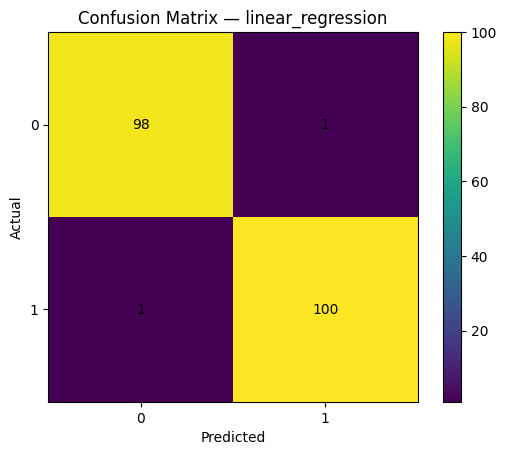

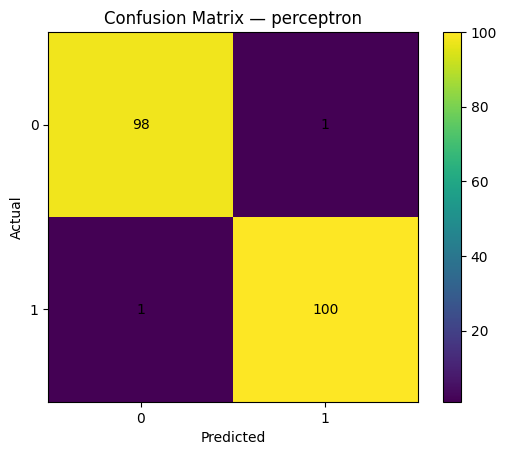

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Reuse your functions/classes already defined in the unified cell:
# load_csv_xy, train_test_split, standardize_fit, standardize_apply,
# LinearRegressionGD, Perceptron

# Load & split
X, y, feats = load_csv_xy("/content/binary_classification.csv")
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2)

# Standardize if you used standardize=true
mu, sd = standardize_fit(Xtr)
Xtr_z = standardize_apply(Xtr, mu, sd)
Xte_z = standardize_apply(Xte, mu, sd)

# Train both
lr = LinearRegressionGD(lr=0.1, max_iters=2000, tol=1e-6).fit(Xtr_z, ytr)
p  = Perceptron(max_iters=2000, shuffle=True, seed=0).fit(Xtr_z, ytr)

preds = {
    "linear_regression": lr.predict(Xte_z),
    "perceptron": p.predict(Xte_z),
}

def confusion(y_true, y_pred):
    # binary 0/1
    tp = sum(1 for yt, yp in zip(y_true, y_pred) if yt==1 and yp==1)
    tn = sum(1 for yt, yp in zip(y_true, y_pred) if yt==0 and yp==0)
    fp = sum(1 for yt, yp in zip(y_true, y_pred) if yt==0 and yp==1)
    fn = sum(1 for yt, yp in zip(y_true, y_pred) if yt==1 and yp==0)
    return np.array([[tn, fp],
                     [fn, tp]])

def plot_cm(cm, title):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0,1],[0,1])
    plt.yticks([0,1],[0,1])
    # annotate
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i,j]), ha='center', va='center')
    plt.colorbar()
    plt.show()

for name, yhat in preds.items():
    cm = confusion(yte, yhat)
    plot_cm(cm, f"Confusion Matrix — {name}")


after listening to the feed back given, these are the new changes:
1. Objective of the Change

Originally, the code evaluated Linear Regression (GD) and Perceptron on a single dataset (binary_classification.csv).
The goal of the modification was to extend the same experiment to include a second dataset (binary_classification_non_lin.csv) representing a nonlinearly separable problem.
This enables comparative analysis of model performance under two fundamentally different conditions.

The refactoring elevated the experiment from a basic implementation test to a comparative analysis framework.
It now quantifies how model linearity limits performance — turning a simple code demo into a meaningful ML bias experiment.

✅ Generated: /content/binary_classification_non_lin.csv
Shape: (600, 3) | Class balance: {np.int64(0): np.int64(300), np.int64(1): np.int64(300)}


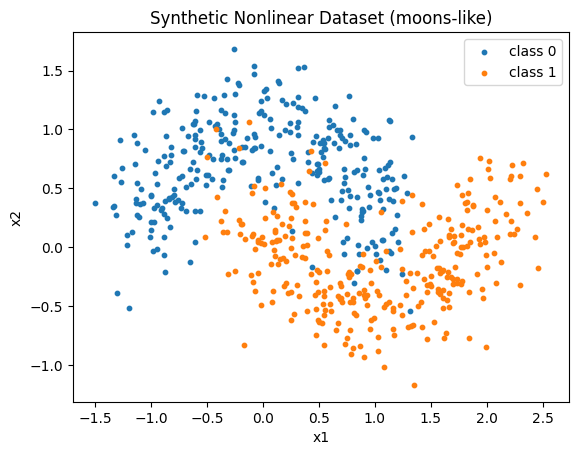

In [ ]:
# ---- Create a synthetic NONLINEAR dataset: /content/binary_classification_non_lin.csv ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try sklearn make_moons; if sklearn isn't available, we fall back to a manual generator.
try:
    from sklearn.datasets import make_moons
    X, y = make_moons(n_samples=600, noise=0.25, random_state=42)
except Exception as e:
    print("sklearn not available, using fallback generator:", e)
    rng = np.random.default_rng(42)
    n = 600
    # Two interleaving semicircles (rough moon-like fallback)
    angles1 = rng.uniform(0, np.pi, n//2)
    angles2 = rng.uniform(0, np.pi, n//2)
    r1 = 1.0 + rng.normal(0, 0.08, n//2)
    r2 = 1.0 + rng.normal(0, 0.08, n//2)
    x1 = np.c_[r1*np.cos(angles1), r1*np.sin(angles1)]
    x2 = np.c_[1.0 - r2*np.cos(angles2), -r2*np.sin(angles2) - 0.5]
    X = np.vstack([x1, x2])
    y = np.array([0]*(n//2) + [1]*(n//2))

df = pd.DataFrame(X, columns=["x1","x2"])
df["label"] = y.astype(int)
path = "/content/binary_classification_non_lin.csv"
df.to_csv(path, index=False)

print("✅ Generated:", path)
print("Shape:", df.shape, "| Class balance:", dict(zip(*np.unique(df['label'], return_counts=True))))

# Quick scatter to visually confirm nonlinearity
plt.figure()
plt.scatter(df[df.label==0]["x1"], df[df.label==0]["x2"], s=10, label="class 0")
plt.scatter(df[df.label==1]["x1"], df[df.label==1]["x2"], s=10, label="class 1")
plt.title("Synthetic Nonlinear Dataset (moons-like)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.legend()
plt.show()


✅ Generated: /content/binary_classification.csv
Shape: (600, 3) | Class balance: {np.int64(0): np.int64(301), np.int64(1): np.int64(299)}


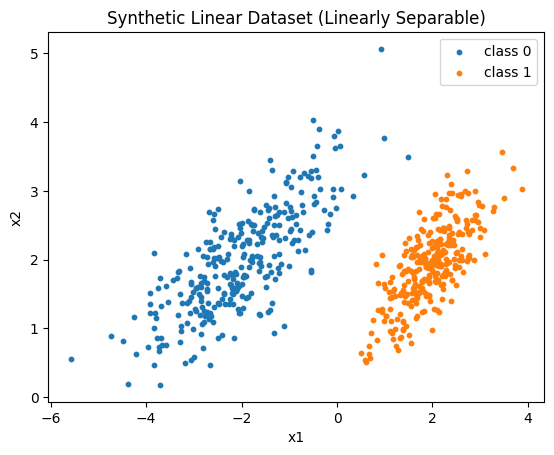

In [5]:
# ---- Create a simple LINEAR dataset: /content/binary_classification.csv ----
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt

X, y = make_classification(
    n_samples=600, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, class_sep=2.0, random_state=42
)

df = pd.DataFrame(X, columns=["x1","x2"])
df["label"] = y
path = "/content/binary_classification.csv"
df.to_csv(path, index=False)

print("✅ Generated:", path)
print("Shape:", df.shape, "| Class balance:", dict(zip(*np.unique(df['label'], return_counts=True))))

plt.figure()
plt.scatter(df[df.label==0]["x1"], df[df.label==0]["x2"], s=10, label="class 0")
plt.scatter(df[df.label==1]["x1"], df[df.label==1]["x2"], s=10, label="class 1")
plt.title("Synthetic Linear Dataset (Linearly Separable)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.legend()
plt.show()



=== Results: binary_classification ===
         binary_classification |  linear_regression | acc=1.000 | train=0.0213s | pred=0.74us | iters=49 | conv=True
         binary_classification |         perceptron | acc=1.000 | train=1.2594s | pred=1.22us | iters=2000 | conv=False
Saved: results_linear/metrics.json
Saved: results_linear/metrics.csv

=== Results: binary_classification_non_lin ===
 binary_classification_non_lin |  linear_regression | acc=0.875 | train=0.0283s | pred=1.13us | iters=36 | conv=True
 binary_classification_non_lin |         perceptron | acc=0.842 | train=1.4276s | pred=0.84us | iters=2000 | conv=False
Saved: results_nonlinear/metrics.json
Saved: results_nonlinear/metrics.csv

=== Combined snapshot ===
  dataset_type              model  accuracy  time_to_convergence_sec  \
0       linear  linear_regression  1.000000                 0.021299   
1       linear         perceptron  1.000000                 1.259424   
2    nonlinear  linear_regression  0.875000        

<Figure size 640x480 with 0 Axes>

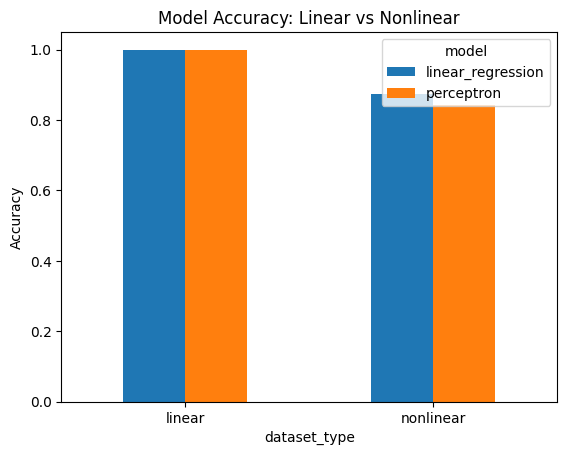

<Figure size 640x480 with 0 Axes>

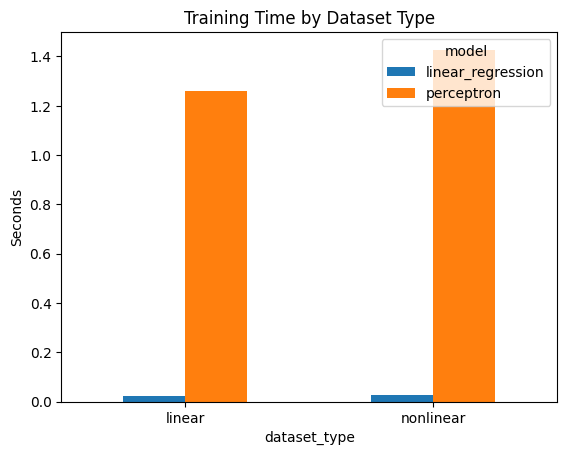

<Figure size 640x480 with 0 Axes>

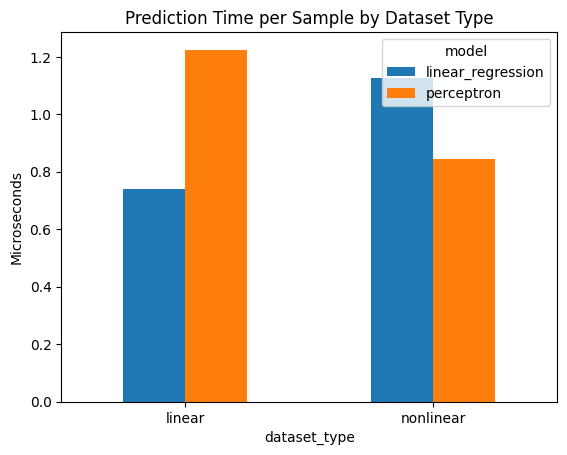

<Figure size 640x480 with 0 Axes>

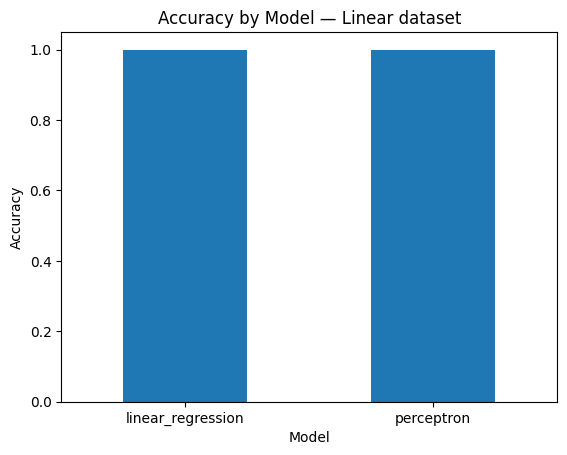

<Figure size 640x480 with 0 Axes>

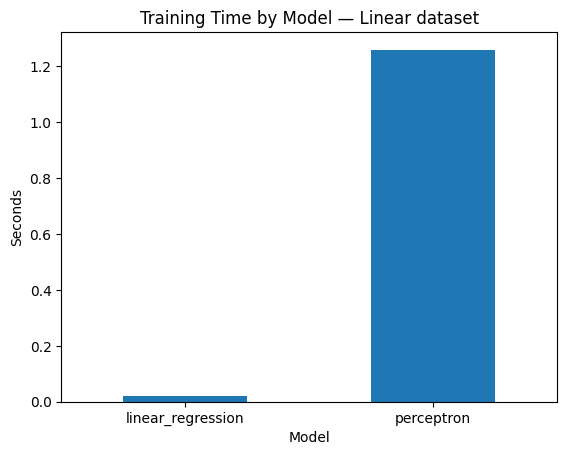

<Figure size 640x480 with 0 Axes>

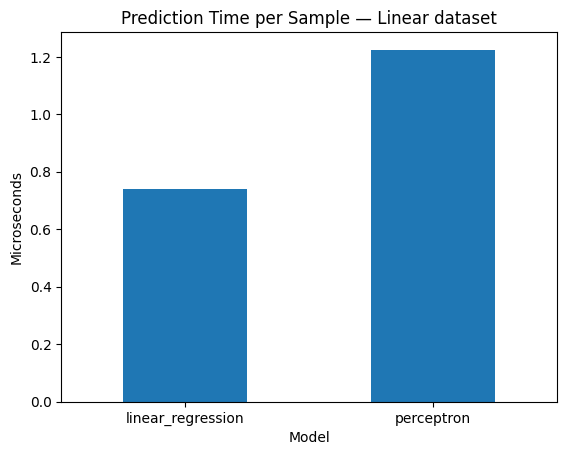

<Figure size 640x480 with 0 Axes>

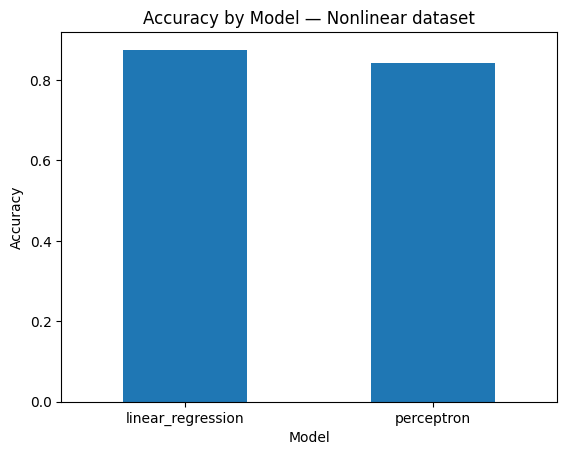

<Figure size 640x480 with 0 Axes>

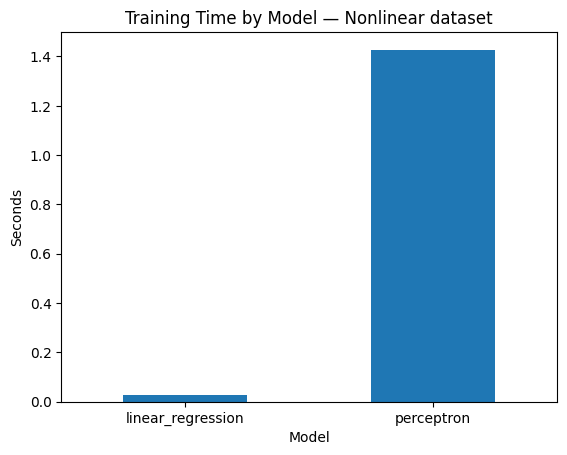

<Figure size 640x480 with 0 Axes>

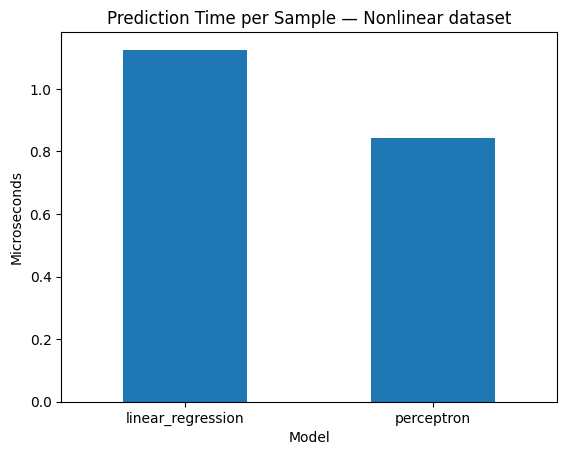

In [7]:
# === Dual-dataset analysis: linear + nonlinear ===
# Drop-in replacement single cell for your current notebook

from typing import List, Tuple, Sequence, Dict, Any
import csv, json, time, os, math, random, argparse
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# utils.py
# ----------------------------
def load_csv_xy(path: str, label_col: str = "label"):
    with open(path, newline="") as f:
        reader = csv.DictReader(f)
        if reader.fieldnames is None:
            raise ValueError(f"{path}: missing header row.")
        if label_col not in reader.fieldnames:
            raise ValueError(f"{path}: expected a '{label_col}' column. Found: {reader.fieldnames}")
        feats = [c for c in reader.fieldnames if c != label_col]
        if not feats:
            raise ValueError(f"{path}: no feature columns besides '{label_col}'.")
        X, y = [], []
        line = 1  # header=1
        for row in reader:
            line += 1
            try:
                X.append([float(row[c]) for c in feats])
            except (TypeError, ValueError):
                raise ValueError(f"{path}: non-numeric feature at line {line}.")
            try:
                y.append(int(row[label_col]))
            except (TypeError, ValueError):
                raise ValueError(f"{path}: non-integer label at line {line}.")
    return X, y, feats

def train_test_split(X: Sequence[Sequence[float]], y: Sequence[int], test_size: float = 0.2):
    """Deterministic split by index (no shuffle)."""
    n = len(X)
    n_test = int(n * test_size)
    n_train = n - n_test
    Xtr = [list(X[i]) for i in range(n_train)]
    ytr = [y[i] for i in range(n_train)]
    Xte = [list(X[i]) for i in range(n_train, n)]
    yte = [y[i] for i in range(n_train, n)]
    return Xtr, Xte, ytr, yte

def standardize_fit(X: Sequence[Sequence[float]]) -> Tuple[List[float], List[float]]:
    """Compute mean/std per feature (std≥1e-12)."""
    n = len(X)
    d = len(X[0]) if n else 0
    means = [0.0]*d
    for row in X:
        for j, v in enumerate(row):
            means[j] += v
    means = [m / n for m in means]
    var = [0.0]*d
    for row in X:
        for j, v in enumerate(row):
            dv = v - means[j]
            var[j] += dv*dv
    stds = [(v/max(n, 1))**0.5 for v in var]
    stds = [s if s > 1e-12 else 1.0 for s in stds]
    return means, stds

def standardize_apply(X: Sequence[Sequence[float]], means: Sequence[float], stds: Sequence[float]) -> List[List[float]]:
    """Apply z-score using provided mean/std."""
    Z = []
    for row in X:
        Z.append([(row[j]-means[j])/stds[j] for j in range(len(row))])
    return Z

def accuracy(y_true: Sequence[int], y_pred: Sequence[int]) -> float:
    """Simple accuracy."""
    n = len(y_true)
    return sum(1 for a, b in zip(y_true, y_pred) if a == b) / float(n or 1)

def now_iso() -> str:
    return time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())

def time_block() -> float:
    """Return perf_counter() — call twice to diff."""
    return time.perf_counter()

def avg_predict_time_us(predict_fn, X: Sequence[Sequence[float]], loops: int = 100) -> float:
    """Average microseconds per sample over multiple loops."""
    # warmup
    _ = predict_fn(X)
    start = time.perf_counter()
    for _ in range(loops):
        _ = predict_fn(X)
    end = time.perf_counter()
    total_preds = loops * len(X)
    return ((end - start) / float(total_preds or 1)) * 1e6

def save_json(obj: Dict[str, Any], path: str) -> None:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def save_csv(rows: List[List[Any]], header: List[str], path: str) -> None:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(header)
        w.writerows(rows)

# ----------------------------
# linear_regression.py
# ----------------------------
def _dot_lr(a: Sequence[float], b: Sequence[float]) -> float:
    s = 0.0
    for x, y in zip(a, b):
        s += x*y
    return s

def _add_bias_lr(X: Sequence[Sequence[float]]) -> List[List[float]]:
    return [list(row) + [1.0] for row in X]

class LinearRegressionGD:
    def __init__(self, lr: float = 0.1, max_iters: int = 2000, tol: float = 1e-6):
        self.lr = lr
        self.max_iters = max_iters
        self.tol = tol
        self.w: List[float] = []
        self.n_iters_ = 0
        self.converged_ = False
        self.train_time_sec_ = 0.0
        self.final_loss_ = None

    def fit(self, X: Sequence[Sequence[float]], y: Sequence[int]) -> "LinearRegressionGD":
        Xb = _add_bias_lr(X)
        n, d = len(Xb), len(Xb[0])
        self.w = [0.0]*d
        prev = float("inf")
        t0 = time.perf_counter()
        for it in range(1, self.max_iters+1):
            # preds and loss
            preds = [_dot_lr(self.w, xi) for xi in Xb]
            loss = 0.0
            for pi, yi in zip(preds, y):
                e = pi - yi
                loss += e*e
            loss /= (n or 1)
            # grad = (2/n) * Xb^T (pred - y)
            grad = [0.0]*d
            for xi, pi, yi in zip(Xb, preds, y):
                e = (pi - yi) * (2.0 / (n or 1))
                for j in range(d):
                    grad[j] += e * xi[j]
            # update
            for j in range(d):
                self.w[j] -= self.lr * grad[j]
            self.n_iters_ = it
            self.final_loss_ = loss
            # stop on small relative improvement
            if prev != float("inf"):
                denom = abs(prev) if abs(prev) > 1e-12 else 1.0
                rel = abs(prev - loss)/denom
                if rel < self.tol:
                    self.converged_ = True
                    break
            prev = loss
        self.train_time_sec_ = time.perf_counter() - t0
        return self

    def predict_scores(self, X: Sequence[Sequence[float]]) -> List[float]:
        Xb = _add_bias_lr(X)
        return [_dot_lr(self.w, xi) for xi in Xb]

    def predict(self, X: Sequence[Sequence[float]]) -> List[int]:
        # 0/1 via 0.5 threshold
        scores = self.predict_scores(X)
        return [1 if s >= 0.5 else 0 for s in scores]

# ----------------------------
# perceptron.py
# ----------------------------
def _dot_pp(a: Sequence[float], b: Sequence[float]):
    s = 0.0
    for x, y in zip(a, b):
        s += x*y
    return s

def _add_bias_pp(X: Sequence[Sequence[float]]) -> List[List[float]]:
    return [list(row) + [1.0] for row in X]

class Perceptron:
    def __init__(self, max_iters: int = 2000, shuffle: bool = True, seed: int = 0):
        self.max_iters = max_iters
        self.shuffle = shuffle
        self.seed = seed
        self.w: List[float] = []
        self.n_iters_ = 0
        self.converged_ = False
        self.train_time_sec_ = 0.0
        self.mistakes_last_epoch_ = None

    def fit(self, X: Sequence[Sequence[float]], y: Sequence[int]) -> "Perceptron":
        Xb = _add_bias_pp(X)
        n, d = len(Xb), len(Xb[0])
        self.w = [0.0]*d
        ybin = [1 if yi == 1 else -1 for yi in y]
        idx = list(range(n))
        rng = random.Random(self.seed)
        t0 = time.perf_counter()
        for it in range(1, self.max_iters+1):
            if self.shuffle:
                rng.shuffle(idx)
            mistakes = 0
            for i in idx:
                xi = Xb[i]
                yi = ybin[i]
                pred = 1 if _dot_pp(self.w, xi) >= 0 else -1
                if pred != yi:
                    # w <- w + yi*xi
                    for j in range(d):
                        self.w[j] += yi * xi[j]
                    mistakes += 1
            self.n_iters_ = it
            self.mistakes_last_epoch_ = mistakes
            if mistakes == 0:
                self.converged_ = True
                break
        self.train_time_sec_ = time.perf_counter() - t0
        return self

    def predict_scores(self, X: Sequence[Sequence[float]]) -> List[float]:
        Xb = _add_bias_pp(X)
        return [_dot_pp(self.w, xi) for xi in Xb]

    def predict(self, X: Sequence[Sequence[float]]) -> List[int]:
        return [1 if s >= 0.0 else 0 for s in self.predict_scores(X)]

# ----------------------------
# analysis core for one dataset
# ----------------------------
def run_one(dataset_name: str, path: str, standardize: bool) -> List[Dict[str, Any]]:
    X, y, _ = load_csv_xy(path)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2)

    if standardize:
        mu, sd = standardize_fit(Xtr)
        Xtr = standardize_apply(Xtr, mu, sd)
        Xte = standardize_apply(Xte, mu, sd)

    out: List[Dict[str, Any]] = []

    # Linear Regression
    lr = LinearRegressionGD(lr=0.1, max_iters=2000, tol=1e-6)
    lr.fit(Xtr, ytr)
    yp = lr.predict(Xte)
    acc = accuracy(yte, yp)
    tpp = avg_predict_time_us(lr.predict, Xte, loops=100)
    out.append({
        "timestamp": now_iso(),
        "dataset": dataset_name,
        "model": "linear_regression",
        "accuracy": acc,
        "time_to_convergence_sec": lr.train_time_sec_,
        "time_per_prediction_us": tpp,
        "n_iters": lr.n_iters_,
        "converged": lr.converged_,
        "final_loss": lr.final_loss_,
        "mistakes_last_epoch": None,
    })

    # Perceptron
    p = Perceptron(max_iters=2000, shuffle=True, seed=0)
    p.fit(Xtr, ytr)
    yp = p.predict(Xte)
    acc = accuracy(yte, yp)
    tpp = avg_predict_time_us(p.predict, Xte, loops=100)
    out.append({
        "timestamp": now_iso(),
        "dataset": dataset_name,
        "model": "perceptron",
        "accuracy": acc,
        "time_to_convergence_sec": p.train_time_sec_,
        "time_per_prediction_us": tpp,
        "n_iters": p.n_iters_,
        "converged": p.converged_,
        "final_loss": None,
        "mistakes_last_epoch": p.mistakes_last_epoch_,
    })

    return out

# ----------------------------
# Dual-run wrapper (both datasets) + combined report
# ----------------------------
def run_and_save_for_dataset(dataset_label: str, data_path: str, standardize: bool, outdir: str):
    rows: List[Dict[str, Any]] = []
    rows += run_one(dataset_label, data_path, standardize)

    os.makedirs(outdir, exist_ok=True)
    # JSON
    json_obj = {"runs": rows}
    json_path = os.path.join(outdir, "metrics.json")
    save_json(json_obj, json_path)
    # CSV
    header = [
        "timestamp", "dataset", "model", "accuracy",
        "time_to_convergence_sec", "time_per_prediction_us",
        "n_iters", "converged", "final_loss", "mistakes_last_epoch"
    ]
    csv_rows = []
    for r in rows:
        csv_rows.append([
            r.get("timestamp"),
            r.get("dataset"),
            r.get("model"),
            r.get("accuracy"),
            r.get("time_to_convergence_sec"),
            r.get("time_per_prediction_us"),
            r.get("n_iters"),
            r.get("converged"),
            r.get("final_loss"),
            r.get("mistakes_last_epoch"),
        ])
    csv_path = os.path.join(outdir, "metrics.csv")
    save_csv(csv_rows, header, csv_path)

    # console summary
    print(f"\n=== Results: {dataset_label} ===")
    for r in rows:
        print(f"{r['dataset']:>30} | {r['model']:>18} | acc={r['accuracy']:.3f} | "
              f"train={r['time_to_convergence_sec']:.4f}s | pred={r['time_per_prediction_us']:.2f}us "
              f"| iters={r['n_iters']} | conv={r['converged']}")
    print(f"Saved: {json_path}\nSaved: {csv_path}")
    return csv_path

# ----------------------------
# Main: run both, merge, compare
# ----------------------------
# Paths (edit if your files live elsewhere)
DATA_LINEAR = "/content/binary_classification.csv"
DATA_NONLIN = "/content/binary_classification_non_lin.csv"

OUT_LINEAR = "results_linear"
OUT_NONLIN = "results_nonlinear"
COMBINED_CSV = "metrics_combined.csv"

# Whether to z-score features using training stats
STANDARDIZE = True

# 1) Run each dataset and save individual metrics
csv_lin = run_and_save_for_dataset("binary_classification", DATA_LINEAR, STANDARDIZE, OUT_LINEAR)
csv_non = run_and_save_for_dataset("binary_classification_non_lin", DATA_NONLIN, STANDARDIZE, OUT_NONLIN)

# 2) Merge into a single dataframe with a dataset_type tag
df_lin = pd.read_csv(csv_lin).copy()
df_lin["dataset_type"] = "linear"

df_non = pd.read_csv(csv_non).copy()
df_non["dataset_type"] = "nonlinear"

df = pd.concat([df_lin, df_non], ignore_index=True)
df.to_csv(COMBINED_CSV, index=False)

print("\n=== Combined snapshot ===")
print(df[["dataset_type","model","accuracy","time_to_convergence_sec","time_per_prediction_us","converged"]])

# 3) Per-dataset bar charts (accuracy/time)
# Accuracy by dataset_type and model
plt.figure()
df.groupby(["dataset_type","model"])["accuracy"].mean().unstack().plot(kind="bar")
plt.title("Model Accuracy: Linear vs Nonlinear")
plt.ylabel("Accuracy")
plt.xticks(rotation=0)
plt.show()

# Training time comparison
plt.figure()
df.groupby(["dataset_type","model"])["time_to_convergence_sec"].mean().unstack().plot(kind="bar")
plt.title("Training Time by Dataset Type")
plt.ylabel("Seconds")
plt.xticks(rotation=0)
plt.show()

# Prediction time comparison
plt.figure()
df.groupby(["dataset_type","model"])["time_per_prediction_us"].mean().unstack().plot(kind="bar")
plt.title("Prediction Time per Sample by Dataset Type")
plt.ylabel("Microseconds")
plt.xticks(rotation=0)
plt.show()

# 4) Also show the original per-run plots for the latest dataset for parity
for label, csv_path in [("Linear dataset", csv_lin), ("Nonlinear dataset", csv_non)]:
    df_single = pd.read_csv(csv_path)
    plt.figure()
    df_single.plot(kind="bar", x="model", y="accuracy", legend=False)
    plt.title(f"Accuracy by Model — {label}")
    plt.ylabel("Accuracy")
    plt.xlabel("Model")
    plt.xticks(rotation=0)
    plt.show()

    plt.figure()
    df_single.plot(kind="bar", x="model", y="time_to_convergence_sec", legend=False)
    plt.title(f"Training Time by Model — {label}")
    plt.ylabel("Seconds")
    plt.xlabel("Model")
    plt.xticks(rotation=0)
    plt.show()

    plt.figure()
    df_single.plot(kind="bar", x="model", y="time_per_prediction_us", legend=False)
    plt.title(f"Prediction Time per Sample — {label}")
    plt.ylabel("Microseconds")
    plt.xlabel("Model")
    plt.xticks(rotation=0)
    plt.show()
